In [2]:
from rdkit.Chem import AllChem as Chem
import pandas as pd
from Bio import pairwise2
import numpy as np
from functools import partial
from multiprocessing import Pool, cpu_count
import pickle,re
from rdkit.Chem import rdFMCS
from rdkit.Chem import MolToInchiKey
from glob import glob
import matplotlib.pyplot as plt

In [14]:
ligand_info = pd.read_csv('Ligand_info.tsv', sep='\t')
rec_pdbs = pd.read_csv('cri_bindb_old.txt', sep=' ',header=None,usecols=[0,2])
rec_pdbs.columns = ['Rec','Seq']
rec_pdbs.drop_duplicates(subset='Rec',inplace=True)
rec_pdbs.set_index(['Rec'],inplace=True)

/home/anm329/anaconda3/envs/RDK/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (15,19,20,51,57,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
import os
print(os.path.isfile('simi_mat/matrix.pickle'))
with open('simi_mat/matrix.pickle', 'rb') as file:
        (distanceMatrix, target_names,ligandsim) = pickle.load(file)

True


In [4]:
def calcClusterGroups(dists, target_names, t):
    '''dists is a distance matrix (full) for target_names'''
    assigned = set()
    groups = []
    for i in range(dists.shape[0]):
        if i not in assigned:
            group = assignGroup(dists, t, set([i]),target_names)
            groups.append(group)
            assigned.update(group)
    return [set(target_names[i] for i in g) for g in groups]


In [5]:
def assignGroup(dists, t, explore, names):
    '''group targets that are less than t away from each other and what's in explore'''
    group = set(explore)
    while explore:
        frontier = set()
        for i in explore:
            for j in range(dists.shape[1]):
                if j not in group:
                    #add to the group if protein is close by threshold t (these are distances - default 0.5)
                    #also add if the ligands are more similar (not distance) than ligandt and 
                    #the protein is closer than t2 (default 0.8 - meaning more than 20% similar)
                    if dists[i][j] < t:
                        group.add(j)
                        frontier.add(j)                
                                        
        explore = frontier
    return group



In [16]:
def cUTDM2(needed, options):
    '''compute distance between target pair'''
    mindist = 1.0
    best_opt=[]
    substring = False
    for idx,opt in enumerate(options):
        score = pairwise2.align.globalxx(needed, opt, score_only=True)
        length = max(len(needed), len(opt))
        distance = (length-score)/length
        if distance < mindist:
            mindist = distance
            best_opt = [idx]
            substring = needed in opt
        elif distance == mindist:
            best_opt.append(idx)
    return best_opt, mindist, substring

In [7]:
similarity = 0.9
thresh = 1-similarity 
cluster_groups = calcClusterGroups(distanceMatrix, target_names, thresh)

In [8]:
#for group in cluster_groups:
final_df = pd.DataFrame(columns=['Receptor','mol','file','BindingDB MonomerID','Inchi Key'])
seen_recs = set()
for idx,group in enumerate(cluster_groups):
    lig_mols = []
    for rec in group:
        for lig in glob('separated_sets/{}/*.sdf'.format(rec)):
            mol = Chem.MolFromMolFile(lig,sanitize=False)
            filename= lig.split('/')[-1]
            if mol is None:
                print(filename)
            lig_id = re.findall(r'\d+',mol.GetProp('_Name'))[0]
            lig_mols.append([rec,mol,filename,lig_id,MolToInchiKey(mol)])
    group_df = pd.DataFrame(data=lig_mols,columns=['Receptor','mol','file','BindingDB MonomerID','Inchi Key'])
    no_dup_group = group_df.drop_duplicates(subset='Inchi Key')
    final_df = final_df.append(no_dup_group,ignore_index=True)
    
        

In [21]:
print('{} unique receptors'.format(len(final_df['Receptor'].unique())))
experimental_df = final_df.groupby('Receptor').filter(lambda x: len(x) > 1) # make sure receptors have more than 1 ligand
print('{} unique receptors with greater than 1 ligand'.format(len(experimental_df['Receptor'].unique())))
experimental_df.to_csv('best_experimental_df_475recs.txt', sep=' ', columns=['Receptor','file','BindingDB MonomerID','Inchi Key'],header=False,index=False)

526 unique receptors
475 unique receptors with greater than 1 ligand


In [28]:
experimental_df = pd.read_csv('best_experimental_df_475recs.txt', sep=' ', names=['Receptor','file','BindingDB MonomerID','Inchi Key'],header=None)

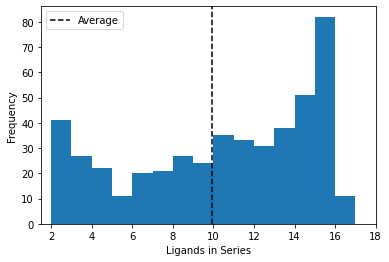

In [7]:
plt.hist(experimental_df.groupby('Receptor').count()['file'],bins=np.arange(1,max(experimental_df.groupby('Receptor').count()['file']),1),align='mid')
plt.axvline(x=np.mean(experimental_df.groupby('Receptor').count()['file']),label='Average',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1.5,max(experimental_df.groupby('Receptor').count()['file'])])
plt.ylabel('Frequency')
plt.legend()

In [17]:
IC50=dict()
bad_rows=[]
experimental_df.assign(IC50=np.nan)
for idx, row in experimental_df.iterrows():
    base_info = ligand_info[ligand_info['BindingDB MonomerID'] == int(row['BindingDB MonomerID'])]
    pertinent_info = base_info[base_info['BindingDB Target Chain  Sequence'].notna()]
    key='{}:{}'.format(row['Receptor'],row['BindingDB MonomerID'])
    if len(pertinent_info) == 1:
        IC50[key] = pertinent_info['IC50 (nM)'].item()
        experimental_df.at[idx,'IC50'] = pertinent_info['IC50 (nM)'].item()
    elif len(pertinent_info) > 1:
        sequences = pertinent_info['BindingDB Target Chain  Sequence'].values.tolist()
        idx_good, dist, sub = cUTDM2(rec_pdbs.loc[row['Receptor'],'Seq'],sequences)
        IC50[key] = pertinent_info.iloc[idx_good,:]['IC50 (nM)']
        if len(idx_good) == 1:
            experimental_df.at[idx,'IC50'] = pertinent_info.iloc[idx_good]['IC50 (nM)'].item()
            experimental_df.at[idx,'distance'] = dist
        else:
            experimental_df.at[idx,'distance'] = dist
            experimental_df.at[idx,'IC50'] = pertinent_info.iloc[idx_good]['IC50 (nM)'].dropna().values.tolist()
    else:
        bad_rows.append(row)
        

In [18]:
def isFloat(val):
    try:
        float(val)
        return True
    except:
        return False

In [19]:
def pullOutNumeric(invar):
    if isinstance(invar,str):
        if invar.strip(' ><').isnumeric() or isFloat(invar):
            return float(invar.strip(' ><'))
        else:
            return np.nan
    elif isinstance(invar, (int, float)):
            return float(invar)
    else:
        return [float(val.strip(' ><')) for val in invar if val.strip(' ><').isnumeric() or isFloat(val.strip(' ><'))]

In [20]:
experimental_df['IC50 nums'] = experimental_df['IC50'].apply(pullOutNumeric)
experimental_df['IC50 avg'] = experimental_df['IC50 nums'].apply(lambda x: np.nanmean(np.asarray(x, dtype=np.float32)))
experimental_df['IC50 var'] = experimental_df['IC50 nums'].apply(lambda x: np.nanvar(np.asarray(x, dtype=np.float32)))

<ipython-input-20-2983d441a3e9>:2: RuntimeWarning: Mean of empty slice
  experimental_df['IC50 avg'] = experimental_df['IC50 nums'].apply(lambda x: np.nanmean(np.asarray(x, dtype=np.float32)))
<ipython-input-20-2983d441a3e9>:3: RuntimeWarning: Degrees of freedom <= 0 for slice.
  experimental_df['IC50 var'] = experimental_df['IC50 nums'].apply(lambda x: np.nanvar(np.asarray(x, dtype=np.float32)))


In [123]:
with_sdf_data = experimental_df.copy()
for idx, row in with_sdf_data.iterrows():
    if not np.isnan(row['IC50 avg']):
        continue
    try:
        with_sdf_data.at[idx, 'IC50 avg'] = BindingDBAffinities[(BindingDBAffinities['Receptor'] == row['Receptor']) & (BindingDBAffinities['BindingDB MonomerID'] == row['BindingDB MonomerID'])]['IC50']
    except:
        print(row['Receptor'],row['BindingDB MonomerID'])

In [132]:
sdf_bef_lig_check = with_sdf_data[with_sdf_data['IC50 avg'].notna()]
sdf_ic50_vals = sdf_bef_lig_check.groupby('Receptor').filter(lambda x: len(x) > 1) # make sure receptors have more than 1 ligand
sdf_ic50_vals['pIC50'] = sdf_ic50_vals['IC50 avg'].apply(lambda x: -np.log10(x)) #note that this is the negative log10 of the value
print('{} unique receptors with greater than 1 ligand'.format(len(sdf_ic50_vals['Receptor'].unique())))
sdf_ic50_vals.sort_values(by=['Receptor','file'],inplace=True)
sdf_ic50_vals.to_csv('sdf_final_ic50_vals.txt', sep=' ', columns=['Receptor','file','BindingDB MonomerID','IC50 avg', 'IC50 var','pIC50'],header=False,index=False)

472 unique receptors with greater than 1 ligand


In [133]:
before_lig_check = experimental_df[experimental_df['IC50 avg'].notna()]
ic50_vals = before_lig_check.groupby('Receptor').filter(lambda x: len(x) > 1) # make sure receptors have more than 1 ligand
ic50_vals['pIC50'] = ic50_vals['IC50 avg'].apply(lambda x: -np.log10(x)) #note that this is the negative log10 of the value
print('{} unique receptors with greater than 1 ligand'.format(len(ic50_vals['Receptor'].unique())))
ic50_vals.sort_values(by=['Receptor','file'],inplace=True)
ic50_vals.to_csv('final_ic50_vals.txt', sep=' ', columns=['Receptor','file','BindingDB MonomerID','IC50 avg', 'IC50 var','pIC50'],header=False,index=False)

361 unique receptors with greater than 1 ligand


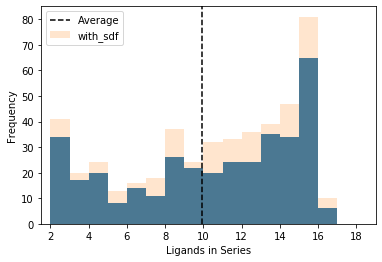

In [127]:
plt.hist(ic50_vals.groupby('Receptor').count()['mol'],bins=np.arange(1,max(ic50_vals.groupby('Receptor').count()['mol']),1),align='mid')
plt.hist(sdf_ic50_vals.groupby('Receptor').count()['mol'],bins=np.arange(1,max(sdf_ic50_vals.groupby('Receptor').count()['mol']),1),align='mid',label='with_sdf',alpha=0.2)
plt.axvline(x=np.mean(ic50_vals.groupby('Receptor').count()['mol']),label='Average',color='k',linestyle='--')
plt.xlabel('Ligands in Series')
plt.xlim([1.5,max(experimental_df.groupby('Receptor').count()['mol'])])
plt.ylabel('Frequency')
plt.legend()

Text(0, 0.5, 'Frequency')

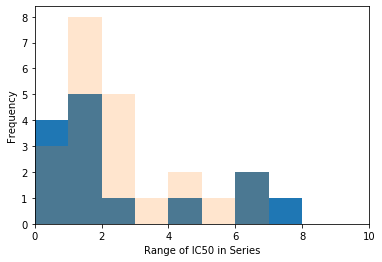

In [130]:
plt.hist(ic50_vals[['Receptor','IC50 avg']].groupby('Receptor').max()['IC50 avg']-ic50_vals[['Receptor','IC50 avg']].groupby('Receptor').min()['IC50 avg'],bins=np.arange(0,10,1),align='mid')
plt.hist(sdf_ic50_vals[['Receptor','IC50 avg']].groupby('Receptor').max()['IC50 avg']-sdf_ic50_vals[['Receptor','IC50 avg']].groupby('Receptor').min()['IC50 avg'],bins=np.arange(0,10,1),align='mid',alpha=0.2,label='with sdf')
plt.xlabel('Range of IC50 in Series')
plt.xlim([0,10])
plt.ylabel('Frequency')

## Using just the affinity values provided in the downloaded sdfs

In [32]:
important_recs = experimental_df['Receptor'].unique().tolist()

BindingDBAffinities = pd.DataFrame(columns=['Receptor','BindingDB MonomerID','IC50'])
for file in glob('separated_sets/sdf_files/*.sdf'):
    if '3D.sdf' in file:
        continue
    liginfo = []
    receptor = re.findall(r'/(....)_Validation_Affinities.sdf',file)[0]
    if receptor not in important_recs:
        continue
    mono_id,ic="",0
    bdbid,affdata=False,False
    with open(file) as mol_file:
        for line in mol_file:
            if 'BindingDB monomerid' in line:
                bdbid=True
                continue
            if bdbid:
                mono_id = line.strip()
                bdbid=False
                continue
            if 'Enzymologic: Ki nM' in line:
                affdata=True
                continue
            if affdata:
                ic = float(line)
                affdata=False
                continue
            if 'Enzymologic' in line:
                print(line)
            if '$$$$' in line:
                liginfo.append([receptor,mono_id,ic])
                mono_id,ic="",0
    receptor_df = pd.DataFrame(data=liginfo,columns=['Receptor','BindingDB MonomerID','IC50'])
    BindingDBAffinities = BindingDBAffinities.append(receptor_df,ignore_index=True)
        
    

In [21]:
hist_of_diffs = []
for rec in important_recs:
    sdf_info = BindingDBAffinities[BindingDBAffinities['Receptor'] == rec]
    tsv_info = experimental_df[(experimental_df['Receptor'] == rec)]
    tsv_info.head()
    for lig in sdf_info['BindingDB MonomerID'].unique().tolist():
        sdf_val=sdf_info[sdf_info['BindingDB MonomerID']==lig]['IC50'].item()
        tsv_stuff = tsv_info[tsv_info['BindingDB MonomerID']==lig]['IC50 avg']
        if len(tsv_stuff) != 1:
            print(rec)
            print(tsv_stuff.head())
            continue
        tsv_val = tsv_stuff.item()
        diff = np.abs(sdf_val-tsv_val)
        hist_of_diffs.append(diff)


2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
2GSS
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: float64)
1AO8
Series([], Name: IC50 avg, dtype: f

1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1OIQ
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: float64)
1P2A
Series([], Name: IC50 avg, dtype: f

3N2P
Series([], Name: IC50 avg, dtype: float64)
3N2P
Series([], Name: IC50 avg, dtype: float64)
3N2P
Series([], Name: IC50 avg, dtype: float64)
3N2P
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
2Q1B
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: float64)
3IBI
Series([], Name: IC50 avg, dtype: f

Series([], Name: IC50 avg, dtype: float64)
1CNW
Series([], Name: IC50 avg, dtype: float64)
1CNW
Series([], Name: IC50 avg, dtype: float64)
1CNW
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
2HD6
Series([], Name: IC50 avg, dtype: float64)
3B4F
Series([], Name: IC50 avg, dtype: float64)
3B4F
Series([], Name: IC50 avg, dtype: float64)
3B4F
Series([], Name: IC50 avg, dtype: float6

1BZJ
Series([], Name: IC50 avg, dtype: float64)
1BZJ
Series([], Name: IC50 avg, dtype: float64)
1BZJ
Series([], Name: IC50 avg, dtype: float64)
1BZJ
Series([], Name: IC50 avg, dtype: float64)
1BZJ
Series([], Name: IC50 avg, dtype: float64)
1BZJ
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: float64)
2F71
Series([], Name: IC50 avg, dtype: f

3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
3G0X
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: float64)
2FPY
Series([], Name: IC50 avg, dtype: f

2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
2TCL
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
3AYK
Series([], Name: IC50 avg, dtype: float64)
1HFC
Series([], Name: IC50 avg, dtype: f

Series([], Name: IC50 avg, dtype: float64)
1LD8
Series([], Name: IC50 avg, dtype: float64)
1LD8
Series([], Name: IC50 avg, dtype: float64)
1LD8
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1W6H
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float64)
1LF3
Series([], Name: IC50 avg, dtype: float6

2HY0
Series([], Name: IC50 avg, dtype: float64)
2HY0
Series([], Name: IC50 avg, dtype: float64)
2HY0
Series([], Name: IC50 avg, dtype: float64)
2HY0
Series([], Name: IC50 avg, dtype: float64)
2HY0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
4FT0
Series([], Name: IC50 avg, dtype: float64)
2E9N
Series([], Name: IC50 avg, dtype: float64)
2E9N
Series([], Name: IC50 avg, dtype: float64)
2E9N
Series([], Name: IC50 avg, dtype: float64)
2E9N
Series([], Name: IC50 avg, dtype: f

4AN0
Series([], Name: IC50 avg, dtype: float64)
4AN0
Series([], Name: IC50 avg, dtype: float64)
4AN0
Series([], Name: IC50 avg, dtype: float64)
4AN0
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
4DBU
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: float64)
1ZQ5
Series([], Name: IC50 avg, dtype: f

1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
1YZ3
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: float64)
2NVD
Series([], Name: IC50 avg, dtype: f

2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
2V13
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: float64)
3SFC
Series([], Name: IC50 avg, dtype: f

2F1O
Series([], Name: IC50 avg, dtype: float64)
2F1O
Series([], Name: IC50 avg, dtype: float64)
2F1O
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2F94
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: float64)
2UYM
Series([], Name: IC50 avg, dtype: f

2PZY
Series([], Name: IC50 avg, dtype: float64)
2PZY
Series([], Name: IC50 avg, dtype: float64)
2PZY
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2JDO
Series([], Name: IC50 avg, dtype: float64)
2UW9
Series([], Name: IC50 avg, dtype: float64)
2UW9
Series([], Name: IC50 avg, dtype: float64)
2UW9
Series([], Name: IC50 avg, dtype: f

2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2P4I
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: float64)
2OSC
Series([], Name: IC50 avg, dtype: f

2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2WEY
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: float64)
2Y0J
Series([], Name: IC50 avg, dtype: f

3CH6
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CZR
Series([], Name: IC50 avg, dtype: float64)
3CQU
Series([], Name: IC50 avg, dtype: float64)
3CQU
Series([], Name: IC50 avg, dtype: float64)
3CQU
Series([], Name: IC50 avg, dtype: float64)
3CQU
Series([], Name: IC50 avg, dtype: f

3FR2
Series([], Name: IC50 avg, dtype: float64)
3FR2
Series([], Name: IC50 avg, dtype: float64)
3FR2
Series([], Name: IC50 avg, dtype: float64)
3FR2
Series([], Name: IC50 avg, dtype: float64)
3FR2
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3FXV
Series([], Name: IC50 avg, dtype: float64)
3H3C
Series([], Name: IC50 avg, dtype: float64)
3H3C
Series([], Name: IC50 avg, dtype: float64)
3H3C
Series([], Name: IC50 avg, dtype: float64)
3H3C
Series([], Name: IC50 avg, dtype: float64)
3H3C
Series([], Name: IC50 avg, dtype: f

3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3O96
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: float64)
3OCS
Series([], Name: IC50 avg, dtype: f

0
0


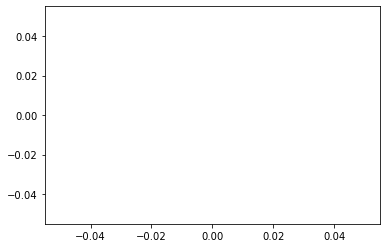

In [22]:
#plt.scatter(range(len(hist_of_diffs)),hist_of_diffs)
arraydif = np.array(hist_of_diffs)
print(len(arraydif))
smul = arraydif[arraydif>5]
zeros = arraydif[arraydif<1e-5]
plt.scatter(range(len(smul)),smul)
print(len(zeros))

As you can see above, there is about half that are the same between the two data types (tsv and sdf). Though the half that are not identical between the two data sources have very major discrepancies.

In [42]:
only_sdf_data = experimental_df.copy()
for idx, row in only_sdf_data.iterrows():
    only_sdf_data.at[idx,'IC50 sdf'] = BindingDBAffinities[(BindingDBAffinities['Receptor'] == row['Receptor']) & (BindingDBAffinities['BindingDB MonomerID'] == str(row['BindingDB MonomerID']))]['IC50'].item()

In [43]:
only_bef_lig_check = only_sdf_data[only_sdf_data['IC50 sdf'].notna()]
sdf_only_ic50_vals = only_bef_lig_check.groupby('Receptor').filter(lambda x: len(x) > 1) # make sure receptors have more than 1 ligand
sdf_only_ic50_vals['pIC50'] = sdf_only_ic50_vals['IC50 sdf'].apply(lambda x: -np.log10(x)) #note that this is the negative log10 of the value
print('{} unique receptors with greater than 1 ligand'.format(len(sdf_only_ic50_vals['Receptor'].unique())))
sdf_only_ic50_vals.sort_values(by=['Receptor','file'],inplace=True)
sdf_only_ic50_vals.to_csv('sdf_only_final_ic50_vals.txt', sep=' ', columns=['Receptor','file','BindingDB MonomerID','IC50 sdf','pIC50'],header=False,index=False)

475 unique receptors with greater than 1 ligand


# Make the Model Training Files (Types File)

In [58]:
#stuff to make the training files
from itertools import permutations,combinations
import math
import requests
from bs4 import BeautifulSoup

In [123]:
def searchRCSBStructPage(s):
    ligs = []
    ligand_bigp = s.find(id="smallMoleculespanel")
    ligand_smallt = ligand_bigp.find(id="LigandsMainTable")
    for row in ligand_smallt.find_all(id=re.compile('ligand_row')):
        if 'UNL' in row['id']:
            continue
        data = row.find_all('td')[2]
        ligs.append(data.find_all('br')[1].next_sibling)
    return ligs

In [124]:
def getReferenceLigs(receptors):
    lig_dict = dict()
    for receptor in receptors:
        possible_ligs =[] 
        response = requests.get('https://www.rcsb.org/structure/{}'.format(receptor))
        soupyness = BeautifulSoup(response.content, 'html.parser')
        try:
            lig_dict[receptor] = searchRCSBStructPage(soupyness)
        except:
            try:
                newlig= soupyness.find(id='note_obsoletedBy')
                newreceptor = newlig.find(href=re.compile('/structure/')).text
                response = requests.get('https://www.rcsb.org/structure/{}'.format(newreceptor))
                soupyness = BeautifulSoup(response.content, 'html.parser')
                lig_dict[receptor] = searchRCSBStructPage(soupyness)
            except:
                print(receptor)
    return lig_dict

In [125]:
recs = sdf_only_ic50_vals['Receptor'].unique()
reference_dict = getReferenceLigs(recs)
train_groups = sdf_only_ic50_vals.groupby('Receptor')


In [126]:
sdf_only_ic50_vals['Reference'] = sdf_only_ic50_vals.apply(lambda x: x['Inchi Key'] in reference_dict[x.Receptor],axis=1)

In [130]:
sdf_only_ic50_vals.sort_values(by=['Receptor','Reference'],ascending=[True,False],ignore_index=True,inplace=True)

### maybe using combinations instead of permutations will be better (reduce it to minimum trainable set)

In [18]:
possible_datas = [sdf_only_ic50_vals]
trainfile_names = ['sdf_only_old_bdb_comb.types']
for i,d in enumerate(possible_datas):
    trainfile = pd.DataFrame(columns=['class','reg','rec','lig1','lig2'])
    grouped = d.groupby('Receptor')
    for rec, group in grouped:
        groupinfo=[]
        for row1,row2 in list(combinations(group.index,2)): ##switched to combinations
            cls = int(float(group.loc[row1,'pIC50']) > float(group.loc[row2,'pIC50']))
            dif = float(group.loc[row1,'pIC50']) - float(group.loc[row2,'pIC50'])
            receptor = '{0}/{0}_R_0.gninatypes'.format(group.loc[row1,'Receptor'])
            lig1 = '{0}/{1}_0.gninatypes'.format(group.loc[row1,'Receptor'],group.loc[row1,'file'].split('.')[0])
            lig2 = '{0}/{1}_0.gninatypes'.format(group.loc[row2,'Receptor'],group.loc[row2,'file'].split('.')[0])
            if dif == np.inf or dif == -np.inf or math.isnan(dif):
                print(lig1,lig2,dif)
                continue
            groupinfo.append([cls,dif,receptor,lig1,lig2])
        group_df = pd.DataFrame(data=groupinfo,columns=['class','reg','rec','lig1','lig2'])
        trainfile = trainfile.append(group_df,ignore_index=True)
    trainfile.to_csv(trainfile_names[i],header=False,index=False,sep=' ',float_format='%.4f')

1Y6Q/1Y6Q00_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q00_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q00_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q01_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q01_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q01_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q02_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q02_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q02_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q03_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q03_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q03_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q04_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q04_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q04_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q05_0.gninatypes 1Y6Q/1Y6Q07_0.gninatypes -inf
1Y6Q/1Y6Q05_0.gninatypes 1Y6Q/1Y6Q08_0.gninatypes -inf
1Y6Q/1Y6Q05_0.gninatypes 1Y6Q/1Y6Q09_0.gninatypes -inf
1Y6Q/1Y6Q0

### Using the same train/test split as the DeltaDelta paper
Using the reference ligand and increasing amounts of additional ligands

In [133]:
possible_datas = [sdf_only_ic50_vals]
trainfile_names = ['sdfo_train_papersplit']
testfile_names = ['sdfo_test_papersplit']
for i,d in enumerate(possible_datas):
    for addnl in range(1,7):
        trainfile = pd.DataFrame(columns=['class','reg','rec','lig1','lig2'])
        testfile = pd.DataFrame(columns=['class','reg','rec','lig1','lig2'])
        grouped = d.groupby('Receptor')
        for rec, group in grouped:
            traingroupinfo=[]
            testgroupinfo=[]
            train_group = group[:(addnl+1)]
            ## Training set first
            for row1,row2 in list(combinations(train_group.index,2)): ##switched to combinations
                cls = int(float(group.loc[row1,'pIC50']) > float(group.loc[row2,'pIC50']))
                dif = float(group.loc[row1,'pIC50']) - float(group.loc[row2,'pIC50'])
                receptor = '{0}/{0}_R_0.gninatypes'.format(group.loc[row1,'Receptor'])
                lig1 = '{0}/{1}_0.gninatypes'.format(group.loc[row1,'Receptor'],group.loc[row1,'file'].split('.')[0])
                lig2 = '{0}/{1}_0.gninatypes'.format(group.loc[row2,'Receptor'],group.loc[row2,'file'].split('.')[0])
                if dif == np.inf or dif == -np.inf or math.isnan(dif):
                    print(lig1,lig2,dif)
                    continue
                traingroupinfo.append([cls,dif,receptor,lig1,lig2])
            # Test set. Using idea that can only compare to values that are in the training set
            for row1,row2 in list(combinations(group.index,2)):
                if not (bool(row1 in train_group.index) ^ bool(row2 in train_group.index)):
                    continue
                cls = int(float(group.loc[row1,'pIC50']) > float(group.loc[row2,'pIC50']))
                dif = float(group.loc[row1,'pIC50']) - float(group.loc[row2,'pIC50'])
                receptor = '{0}/{0}_R_0.gninatypes'.format(group.loc[row1,'Receptor'])
                lig1 = '{0}/{1}_0.gninatypes'.format(group.loc[row1,'Receptor'],group.loc[row1,'file'].split('.')[0])
                lig2 = '{0}/{1}_0.gninatypes'.format(group.loc[row2,'Receptor'],group.loc[row2,'file'].split('.')[0])
                if dif == np.inf or dif == -np.inf or math.isnan(dif):
                    continue
                testgroupinfo.append([cls,dif,receptor,lig1,lig2])
            group_df = pd.DataFrame(data=traingroupinfo,columns=['class','reg','rec','lig1','lig2'])
            trainfile = trainfile.append(group_df,ignore_index=True)
            tgroup_df = pd.DataFrame(data=testgroupinfo,columns=['class','reg','rec','lig1','lig2'])
            testfile = testfile.append(tgroup_df,ignore_index=True)
        trainfile.to_csv('{}_{}.types'.format(trainfile_names[i],str(addnl)),header=False,index=False,sep=' ',float_format='%.4f')
        testfile.to_csv('{}_{}.types'.format(testfile_names[i],str(addnl)),header=False,index=False,sep=' ',float_format='%.4f')